In [1774]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [1775]:
engine = create_engine("sqlite:///data/mta_turnstile.db")

In [1776]:
all_tables = engine.table_names()
all_tables
some_tables = all_tables[0:3]
some_tables

<ipython-input-1776-374e45c4e560>:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  all_tables = engine.table_names()


['turnstile_2019_0105', 'turnstile_2019_0112', 'turnstile_2019_0119']

In [1777]:
dfs = []
for table in some_tables:
    dfs.append(pd.read_sql(table,engine))
    mtadf = pd.concat(dfs)
mtadf.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [1778]:
print('DTYPES:\n',mtadf.dtypes,'\n')
print(mtadf.columns)
print(mtadf.shape)

DTYPES:
 C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object 

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',


In [1779]:
# fix the insane amount of space after 'EXITS'
mtadf.rename(str.strip, axis='columns',inplace=True)
mtadf.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [1780]:
# change DATE and TIME to datetime objects
mtadf['OBSERVED_AT'] = pd.to_datetime(mtadf['DATE']+ ' ' + mtadf['TIME'], 
                                      format='%m/%d/%Y %H:%M:%S')

In [1781]:
# 21 days of data AKA 3 weeks
# mtadf.DATE.value_counts().sort_index()

In [1782]:
# SAVE FOR LATER
# create column for day of week
# mtadf['WEEKDAY']=mtadf['OBSERVED_AT'].dt.dayofweek
# change WEEKDAY from int64 to string Monday-Sunday
'''daymap = {0:'Monday',
          1: 'Tuesday',
          2: 'Wednesday',
          3: 'Thursday',
          4: 'Friday',
          5: 'Saturday',
          6: 'Sunday'}
mtadf['WEEKDAY']=mtadf['WEEKDAY'].map(daymap)
'''

"daymap = {0:'Monday',\n          1: 'Tuesday',\n          2: 'Wednesday',\n          3: 'Thursday',\n          4: 'Friday',\n          5: 'Saturday',\n          6: 'Sunday'}\nmtadf['WEEKDAY']=mtadf['WEEKDAY'].map(daymap)\n"

In [1783]:
# create some other columns based on the datetime object
mtadf['MONTH'] = mtadf.OBSERVED_AT.dt.month
mtadf['DAY'] = mtadf.OBSERVED_AT.dt.day

# don't end up using
# mtadf['HOUR'] = mtadf.OBSERVED_AT.dt.hour
# mtadf['MIN'] = mtadf.OBSERVED_AT.dt.minute

In [1784]:
# create identifyer for each turnstile then drop original columns
mtadf['TURNSTILE'] = mtadf['UNIT'] + '-' + mtadf['C/A'] + '-' + mtadf['SCP']

# didn't end up needing this
# mtadf['TURNSTILE_ID'] = mtadf['UNIT'] + '-' + mtadf['C/A'] + '-' + mtadf['SCP']\
                       # + '-' + mtadf['DATE'] + '-' + mtadf['TIME']

In [1785]:
mtadf.drop(['C/A','UNIT','SCP'],axis=1,inplace=True)

In [1786]:
mtadf.columns

Index(['STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS', 'OBSERVED_AT', 'MONTH', 'DAY', 'TURNSTILE'],
      dtype='object')

In [1787]:
# rearrange order of columns
col_names = ['STATION','TURNSTILE','OBSERVED_AT',
             'DATE','MONTH','DAY','WEEKDAY','TIME',
             'ENTRIES','EXITS',
             'LINENAME','DIVISION','DESC']
mtadf = mtadf.reindex(columns=col_names)
mtadf.head(1)

,STATION,TURNSTILE,OBSERVED_AT,DATE,MONTH,DAY,WEEKDAY,TIME,ENTRIES,EXITS,LINENAME,DIVISION,DESC
0,59 ST,R051-A002-02-00-00,2018-12-29 03:00:00,12/29/2018,12,29,NaN,03:00:00,6889287,2335920,NQR456W,BMT,REGULAR


In [1788]:
# sort the dataframe by station, then month/day/hour/min
mtadf.sort_values(['STATION','MONTH','DAY'],inplace=True)

In [1789]:
mtadf.OBSERVED_AT.dt.hour.value_counts()
#some observations are at HOUR 0 aka midnight

7     55924
11    55079
23    54427
15    54375
3     54336
19    54327
8     40925
16    39071
12    39040
0     38984
4     38978
20    38898
9      4834
5      4493
13     4470
21     4433
17     4431
1      4410
10     3290
6      2783
14     2511
18     2497
2      2459
22     2445
Name: OBSERVED_AT, dtype: int64

In [1790]:
# create an hour offset
one_hour = pd.offsets.Hour()

In [1791]:
# how many rows occur from midnight to midnight:59?
print(mtadf[mtadf.OBSERVED_AT.dt.hour == 0].shape)
print(mtadf.shape)

(38984, 13)
(607420, 13)


In [1792]:
# if the observation was from midnight to midight:59
# subtract 1 hour so the log is included for the previous day
mtadf['OBSERVED_AT'] = mtadf['OBSERVED_AT'].apply(lambda x: x-one_hour if x.hour == 0 else x)

In [1793]:
# check if we have any instances of midnight to midnight:59
mtadf['HOUR'] = mtadf['OBSERVED_AT'].dt.hour
print(mtadf[mtadf['HOUR'] == 0])

Empty DataFrame
Columns: [STATION, TURNSTILE, OBSERVED_AT, DATE, MONTH, DAY, WEEKDAY, TIME, ENTRIES, EXITS, LINENAME, DIVISION, DESC, HOUR]
Index: []


In [1794]:
# get daily cumulative # per turnstile per date
mtadf_ts_daily = (mtadf.groupby(['TURNSTILE','STATION','DATE','LINENAME'],as_index=False)
                        [['ENTRIES','EXITS']].max())
mtadf_ts_daily

,TURNSTILE,STATION,DATE,LINENAME,ENTRIES,EXITS
0,R001-A058-01-00-00,WHITEHALL S-FRY,01/01/2019,R1W,1495716,3470742
1,R001-A058-01-00-00,WHITEHALL S-FRY,01/02/2019,R1W,1496890,3473304
2,R001-A058-01-00-00,WHITEHALL S-FRY,01/03/2019,R1W,1498200,3475903
3,R001-A058-01-00-00,WHITEHALL S-FRY,01/04/2019,R1W,1499417,3478394
4,R001-A058-01-00-00,WHITEHALL S-FRY,01/05/2019,R1W,1499698,3479101
...,...,...,...,...,...,...
100631,R572-N702A-01-03-04,96 ST-2 AVE,01/17/2019,Q,931008,304809
100632,R572-N702A-01-03-04,96 ST-2 AVE,01/18/2019,Q,932433,305272
100633,R572-N702A-01-03-04,96 ST-2 AVE,12/29/2018,Q,909936,297827
100634,R572-N702A-01-03-04,96 ST-2 AVE,12/30/2018,Q,910208,297928


In [1795]:
mtadf_ts_daily[['PREV_DATE','PREV_ENTRIES','PREV_EXITS']]=mtadf_ts_daily\
                            .groupby(['TURNSTILE','STATION'])[['DATE', 'ENTRIES','EXITS']]\
                            .apply(lambda grp: grp.shift(1))
mtadf_ts_daily            

,TURNSTILE,STATION,DATE,LINENAME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,R001-A058-01-00-00,WHITEHALL S-FRY,01/01/2019,R1W,1495716,3470742,NaN,NaN,NaN
1,R001-A058-01-00-00,WHITEHALL S-FRY,01/02/2019,R1W,1496890,3473304,01/01/2019,1495716.0,3470742.0
2,R001-A058-01-00-00,WHITEHALL S-FRY,01/03/2019,R1W,1498200,3475903,01/02/2019,1496890.0,3473304.0
3,R001-A058-01-00-00,WHITEHALL S-FRY,01/04/2019,R1W,1499417,3478394,01/03/2019,1498200.0,3475903.0
4,R001-A058-01-00-00,WHITEHALL S-FRY,01/05/2019,R1W,1499698,3479101,01/04/2019,1499417.0,3478394.0
...,...,...,...,...,...,...,...,...,...
100631,R572-N702A-01-03-04,96 ST-2 AVE,01/17/2019,Q,931008,304809,01/16/2019,929537.0,304322.0
100632,R572-N702A-01-03-04,96 ST-2 AVE,01/18/2019,Q,932433,305272,01/17/2019,931008.0,304809.0
100633,R572-N702A-01-03-04,96 ST-2 AVE,12/29/2018,Q,909936,297827,01/18/2019,932433.0,305272.0
100634,R572-N702A-01-03-04,96 ST-2 AVE,12/30/2018,Q,910208,297928,12/29/2018,909936.0,297827.0


In [1796]:
# drop the rows for the earliest date in the DF for each Turnstile
mtadf_ts_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [1797]:
mtadf_ts_daily.shape

(95814, 9)

In [1798]:
# how many entries are going backwards
mtadf_ts_daily[mtadf_ts_daily['ENTRIES'] < mtadf_ts_daily['PREV_ENTRIES']].shape

(5245, 9)

In [1799]:
# how many turnstiles per station
# mtadf.groupby('STATION')['TURNSTILE'].nunique().describe()

In [1800]:
def get_daily_entries(df):
    #max_count is 30 person per minute through the turnstile
    max_count = (30*60) * 24
    count = df['ENTRIES'] - df['PREV_ENTRIES']
    if count < 0:
        count = -count
        
    if count > max_count:
        count = min(df["ENTRIES"], df["PREV_ENTRIES"])
    
    if count > max_count:
        return 0
    return count

In [1801]:
mtadf_ts_daily['NET_ENTRIES']= mtadf_ts_daily.apply(get_daily_entries, axis=1)

In [1802]:
def get_daily_exits(df):
    max_count = (30*60) * 24
    count = df['EXITS'] - df['PREV_EXITS']
    if count < 0:
        count = -count
        
    if count > max_count:
        count = min(df['EXITS'], df['PREV_EXITS'])
    
    if count > max_count:
        return 0
    return count

In [1803]:
mtadf_ts_daily['NET_EXITS']= mtadf_ts_daily.apply(get_daily_exits, axis=1)

In [1804]:
# create a DF with daily # per STATION per DATE, sum the NET_ENTRIES NET_EXITS per STATION
mtadf_st_daily = mtadf_ts_daily.groupby(['STATION','DATE','LINENAME'],as_index=False)[['NET_ENTRIES','NET_EXITS']].sum()

In [1805]:
# create a column for NET_BUSY
mtadf_st_daily['NET_BUSY'] = mtadf_st_daily['NET_ENTRIES'] + mtadf_st_daily['NET_EXITS']

In [1806]:
# we have a dataframe that shows net entries, net exits, and net busy by station by day!
mtadf_st_daily

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY
0,1 AV,01/02/2019,L,18476.0,21058.0,39534.0
1,1 AV,01/03/2019,L,19866.0,22531.0,42397.0
2,1 AV,01/04/2019,L,20389.0,23633.0,44022.0
3,1 AV,01/05/2019,L,13930.0,16661.0,30591.0
4,1 AV,01/06/2019,L,12021.0,13789.0,25810.0
...,...,...,...,...,...,...
9476,ZEREGA AV,01/17/2019,6,2811.0,2600.0,5411.0
9477,ZEREGA AV,01/18/2019,6,2678.0,2430.0,5108.0
9478,ZEREGA AV,12/29/2018,6,39544.0,28201.0,67745.0
9479,ZEREGA AV,12/30/2018,6,1068.0,1197.0,2265.0


In [1807]:
# put DATE back as a datetime object
mtadf_st_daily['DATE'] = pd.to_datetime(mtadf_st_daily['DATE'])

In [1808]:
mtadf_st_daily['WEEKDAY']=mtadf_st_daily['DATE'].dt.dayofweek
# change WEEKDAY from int64 to string Monday-Sunday
daymap = {0:'Monday',
          1: 'Tuesday',
          2: 'Wednesday',
          3: 'Thursday',
          4: 'Friday',
          5: 'Saturday',
          6: 'Sunday'}
mtadf_st_daily['WEEKDAY']=mtadf_st_daily['WEEKDAY'].map(daymap)

In [1816]:
mtadf_st_daily

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE
0,1 AV,2019-01-02,L,18476.0,21058.0,39534.0,Wednesday,L
1,1 AV,2019-01-03,L,19866.0,22531.0,42397.0,Thursday,L
2,1 AV,2019-01-04,L,20389.0,23633.0,44022.0,Friday,L
3,1 AV,2019-01-05,L,13930.0,16661.0,30591.0,Saturday,L
4,1 AV,2019-01-06,L,12021.0,13789.0,25810.0,Sunday,L
...,...,...,...,...,...,...,...,...
9476,ZEREGA AV,2019-01-17,6,2811.0,2600.0,5411.0,Thursday,6
9477,ZEREGA AV,2019-01-18,6,2678.0,2430.0,5108.0,Friday,6
9478,ZEREGA AV,2018-12-29,6,39544.0,28201.0,67745.0,Saturday,6
9479,ZEREGA AV,2018-12-30,6,1068.0,1197.0,2265.0,Sunday,6


In [1810]:
mtadf_st_daily['LINE'] = mtadf_st_daily['LINENAME'].str.replace('',',')

In [1811]:
mtadf_st_daily.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE
3424,AQUEDUCT RACETR,2019-01-12,A,1911.0,151.0,2062.0,Saturday,",A,"
623,145 ST,2019-01-18,1,9193.0,6792.0,15985.0,Friday,",1,"
1765,33 ST-RAWSON ST,2019-01-13,7,1331.0,1316.0,2647.0,Sunday,",7,"
721,155 ST,2019-01-15,BD,3564.0,2004.0,5568.0,Tuesday,",B,D,"
5094,CLINTON-WASH AV,2019-01-13,G,2627.0,472.0,3099.0,Sunday,",G,"
...,...,...,...,...,...,...,...,...
6871,KINGS HWY,2019-01-16,BQ,20544.0,16977.0,37521.0,Wednesday,",B,Q,"
8906,TIMES SQ-42 ST,2019-01-17,1237ACENQRS,14794.0,7544.0,22338.0,Thursday,",1,2,3,7,A,C,E,N,Q,R,S,"
3426,AQUEDUCT RACETR,2019-01-14,A,1313.0,123.0,1436.0,Monday,",A,"
8725,STERLING ST,2019-01-06,25,2560.0,1841.0,4401.0,Sunday,",2,5,"


In [1812]:
mtadf_st_daily['LINE']=mtadf_st_daily['LINE'].str.strip(',')
mtadf_st_daily.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE
213,111 ST,2018-12-31,7,8573.0,5316.0,13889.0,Monday,7
8521,SENECA AVE,2018-12-31,M,1579.0,1329.0,2908.0,Monday,M
2041,45 ST,2019-01-09,R,7834.0,4634.0,12468.0,Wednesday,R
491,14 ST,2019-01-07,ACEL,19602.0,15367.0,34969.0,Monday,"A,C,E,L"
651,149/GRAND CONC,2019-01-18,245,11996.0,6583.0,18579.0,Friday,"2,4,5"
...,...,...,...,...,...,...,...,...
5549,EASTN PKWY-MUSM,2019-01-02,23,4153.0,3803.0,7956.0,Wednesday,"2,3"
6524,HUNTS POINT AV,2019-01-17,6,10952.0,8989.0,19941.0,Thursday,6
957,174 ST,2019-01-13,25,2818.0,2961.0,5779.0,Sunday,"2,5"
7077,LEXINGTON AV/63,2019-01-13,F,6724.0,6319.0,13043.0,Sunday,F


In [1828]:
dummy = mtadf_st_daily.LINE.str.get_dummies(sep = ",")
dummy.columns

Index(['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'W', 'Z'],
      dtype='object')

In [1819]:
stdf_daily_lines = mtadf_st_daily.merge(dummy, left_index=True, right_index=True)
stdf_daily_lines.sample(frac=.1)

,STATION,DATE,LINENAME,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,LINE,1,2,...,G,J,L,M,N,Q,R,S,W,Z
996,175 ST,2019-01-12,A,6707.0,4130.0,10837.0,Saturday,A,0,0,...,0,0,0,0,0,0,0,0,0,0
97,103 ST-CORONA,2018-12-29,7,218644.0,152241.0,370885.0,Saturday,7,0,0,...,0,0,0,0,0,0,0,0,0,0
5397,DYCKMAN ST,2019-01-06,1,3966.0,2815.0,6781.0,Sunday,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2717,71 ST,2019-01-05,D,3220.0,1244.0,4464.0,Saturday,D,0,0,...,0,0,0,0,0,0,0,0,0,0
2511,6 AV,2018-12-29,FLM123,54946.0,44684.0,99630.0,Saturday,"F,L,M,1,2,3",1,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,LORIMER ST,2018-12-30,LG,3320.0,1173.0,4493.0,Sunday,"L,G",0,0,...,1,0,1,0,0,0,0,0,0,0
4387,BRIGHTON BEACH,2019-01-18,BQ,10282.0,6336.0,16618.0,Friday,"B,Q",0,0,...,0,0,0,0,0,1,0,0,0,0
4383,BRIGHTON BEACH,2019-01-14,BQ,11642.0,6917.0,18559.0,Monday,"B,Q",0,0,...,0,0,0,0,0,1,0,0,0,0
8884,TIMES SQ-42 ST,2019-01-09,ACENQRS1237W,17264.0,21635.0,38899.0,Wednesday,"A,C,E,N,Q,R,S,1,2,3,7,W",1,1,...,0,0,0,0,1,1,1,1,1,0


In [1821]:
stdf_daily_lines.drop(['LINENAME','LINE'],axis=1,inplace=True)

In [1869]:
stdf_daily_lines.groupby('STATION')

NET_ENTRIES                                             \
                      count      mean           std      min       25%   
STATION                                                                  
1 AV                   20.0  22089.60  17678.776525  11989.0  15049.25   
103 ST                 60.0  14221.55  26217.921597   1918.0   4518.25   
103 ST-CORONA          20.0  27357.70  45164.044820  10165.0  14369.25   
104 ST                 40.0   3168.85   6782.854023    567.0   1138.00   
110 ST                 20.0  15543.10  28012.388419   4659.0   7147.25   
...                     ...       ...           ...      ...       ...   
WOODLAWN               20.0  10786.20  23188.206300   2688.0   4539.50   
WORLD TRADE CTR        20.0  26791.60  57867.619392   3777.0  11009.75   
WTC-CORTLANDT          20.0  22080.00  48122.016224   4355.0  11220.00   
YORK ST                20.0   8572.25   3884.573591      0.0   5392.25   
ZEREGA AV              20.0   4365.65   8396.311065    960.0   1614.00   

                                             NET_EXITS                ...  \
                     50%       75%       max     count          mean  ...   
STATION                                                               ...   
1 AV             20107.5  21073.75   95741.0      20.0  24970.450000  ...   
103 ST            9339.0  12552.00  163903.0      60.0  10973.683333  ...   
103 ST-CORONA    19444.0  19763.50  218644.0      20.0  19929.200000  ...   
104 ST            1766.0   1948.75   35566.0      40.0   1744.275000  ...   
110 ST           10814.5  11085.50  134123.0      20.0  13740.300000  ...   
...                  ...       ...       ...       ...           ...  ...   
WOODLAWN          6604.5   6709.25  109081.0      20.0   2305.350000  ...   
WORLD TRADE CTR  16965.0  17480.50  271632.0      20.0  19366.200000  ...   
WTC-CORTLANDT    12222.5  13018.00  226108.0      20.0  17226.100000  ...   
YORK ST          10899.0  11377.00   11769.0      20.0   4986.650000  ...   
ZEREGA AV         2722.0   2815.50   39544.0      20.0   3870.800000  ...   

                   W          Z                                         
                 75%  max count mean      std  min  25%  50%  75%  max  
STATION                                                                 
1 AV             0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
103 ST           0.0  0.0  60.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
103 ST-CORONA    0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
104 ST           0.0  0.0  40.0  0.5  0.50637  0.0  0.0  0.5  1.0  1.0  
110 ST           0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
...              ...  ...   ...  ...      ...  ...  ...  ...  ...  ...  
WOODLAWN         0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
WORLD TRADE CTR  0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
WTC-CORTLANDT    0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
YORK ST          0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  
ZEREGA AV        0.0  0.0  20.0  0.0  0.00000  0.0  0.0  0.0  0.0  0.0  

[377 rows x 208 columns]

In [1879]:
stdf_daily_lines.groupby('G')['STATION'].uninque()

AttributeError: 'SeriesGroupBy' object has no attribute 'uninque'

In [1880]:
for i in '1234567ABCDEFGJLMNQRSWZ':
    grouped = stdf_daily_lines.groupby(i)
    count = grouped.apply(lambda x: x[x[i] == 1])['STATION'].nunique()
    print(f'LINE: {i} \nSTATIONS: {count} ')

LINE: 1 
STATIONS: 61 
LINE: 2 
STATIONS: 53 
LINE: 3 
STATIONS: 38 
LINE: 4 
STATIONS: 30 
LINE: 5 
STATIONS: 45 
LINE: 6 
STATIONS: 41 
LINE: 7 
STATIONS: 25 
LINE: A 
STATIONS: 49 
LINE: B 
STATIONS: 45 
LINE: C 
STATIONS: 44 
LINE: D 
STATIONS: 41 
LINE: E 
STATIONS: 29 
LINE: F 
STATIONS: 50 
LINE: G 
STATIONS: 25 
LINE: J 
STATIONS: 31 
LINE: L 
STATIONS: 26 
LINE: M 
STATIONS: 41 
LINE: N 
STATIONS: 36 
LINE: Q 
STATIONS: 38 
LINE: R 
STATIONS: 49 
LINE: S 
STATIONS: 12 
LINE: W 
STATIONS: 23 
LINE: Z 
STATIONS: 21 


In [1889]:
stdf_7_daily = stdf_daily_lines[stdf_daily_lines['7'] == 1]

In [1924]:
stdf_7_daily = stdf_7_daily[~stdf_7_daily['STATION'].isin(['42 ST-PORT AUTH',
                                                           'TIMES SQ-42 ST',
                                                           '34 ST-HUDSON YD',
                                                           '5 AVE'])]

In [1925]:
stdf_7_daily

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,1,2,3,4,...,G,J,L,M,N,Q,R,S,W,Z
80,103 ST-CORONA,2019-01-02,18976.0,13884.0,32860.0,Wednesday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,103 ST-CORONA,2019-01-03,19402.0,14686.0,34088.0,Thursday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,103 ST-CORONA,2019-01-04,20207.0,14434.0,34641.0,Friday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,103 ST-CORONA,2019-01-05,13035.0,10755.0,23790.0,Saturday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,103 ST-CORONA,2019-01-06,10579.0,9403.0,19982.0,Sunday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9116,VERNON-JACKSON,2019-01-17,15154.0,10098.0,25252.0,Thursday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9117,VERNON-JACKSON,2019-01-18,14662.0,9804.0,24466.0,Friday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9118,VERNON-JACKSON,2018-12-29,210496.0,143714.0,354210.0,Saturday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9119,VERNON-JACKSON,2018-12-30,6647.0,4479.0,11126.0,Sunday,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1928]:
stdf_7_daily_q = stdf_7_daily.dropna(how='all',axis=1)

In [1933]:
stdf_7_daily_q['STATION'].nunique()

21

In [1960]:
stationlist = list(stdf_7_daily_q['STATION'].unique())
stationlist

stdf_7_daily_corona = stdf_7_daily_q[stdf_7_daily_q['STATION'] == '103 ST-CORONA']
stdf_7_daily_corona

,STATION,DATE,NET_ENTRIES,NET_EXITS,NET_BUSY,WEEKDAY,4,5,6,7,B,D,E,F,M,N,Q,R,S,W
80,103 ST-CORONA,2019-01-02,18976.0,13884.0,32860.0,Wednesday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,103 ST-CORONA,2019-01-03,19402.0,14686.0,34088.0,Thursday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,103 ST-CORONA,2019-01-04,20207.0,14434.0,34641.0,Friday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,103 ST-CORONA,2019-01-05,13035.0,10755.0,23790.0,Saturday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,103 ST-CORONA,2019-01-06,10579.0,9403.0,19982.0,Sunday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,103 ST-CORONA,2019-01-07,19326.0,14263.0,33589.0,Monday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,103 ST-CORONA,2019-01-08,19589.0,14181.0,33770.0,Tuesday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,103 ST-CORONA,2019-01-09,19754.0,14537.0,34291.0,Wednesday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,103 ST-CORONA,2019-01-10,19486.0,14133.0,33619.0,Thursday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,103 ST-CORONA,2019-01-11,19737.0,14124.0,33861.0,Friday,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


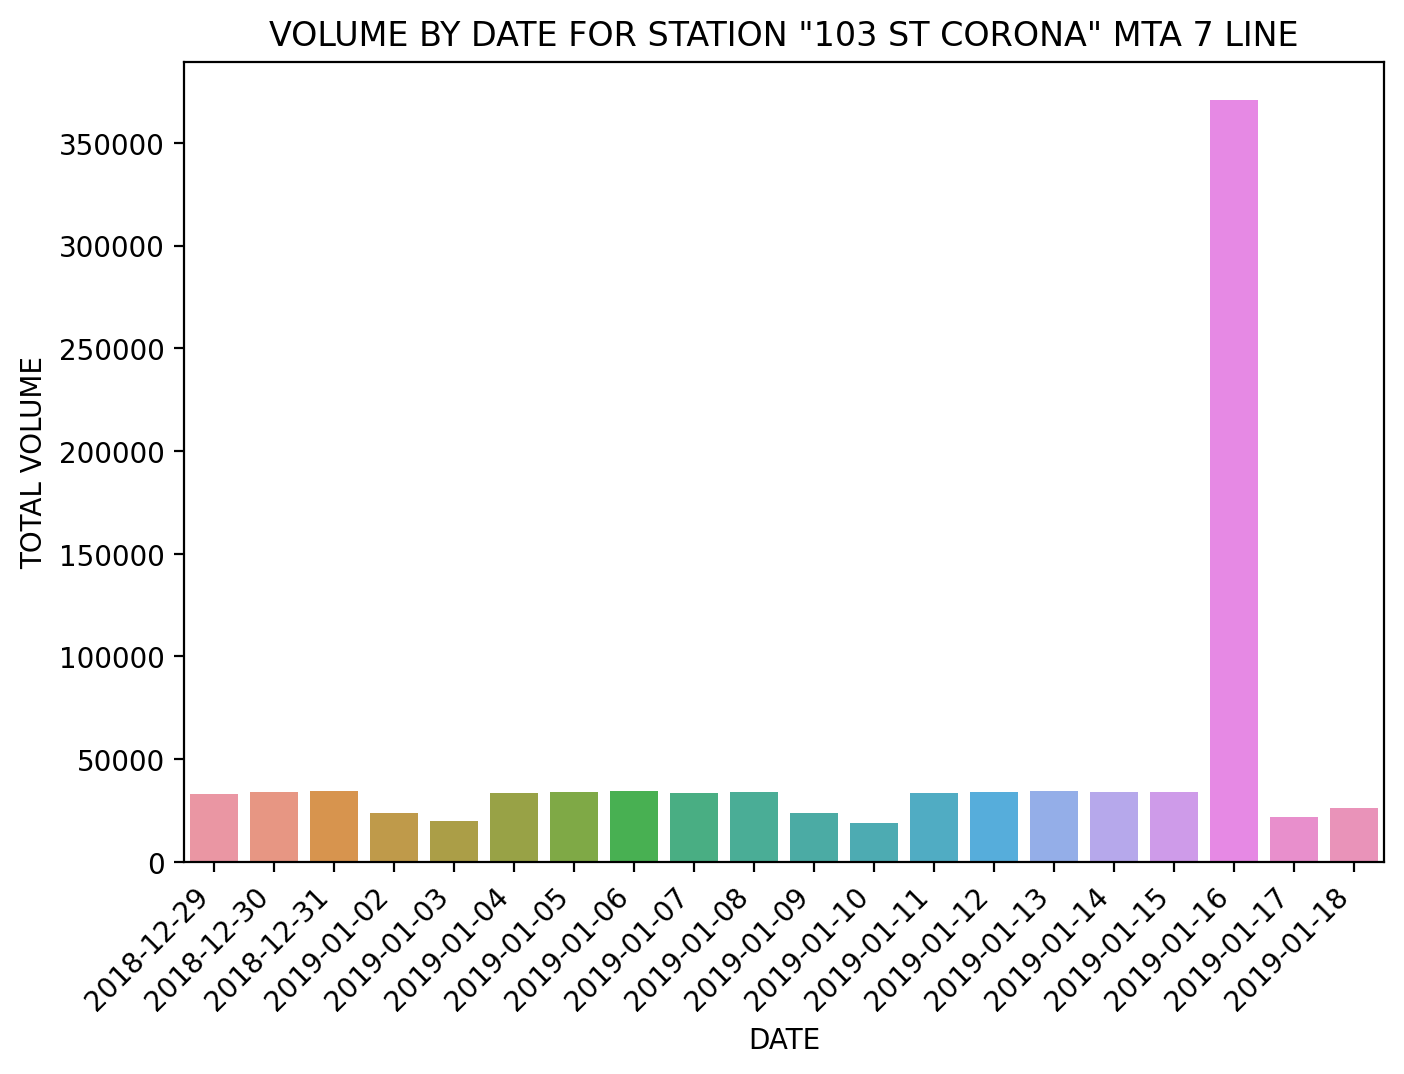

In [1971]:
fig = plt.figure(dpi=200)
axes = fig.add_axes([0,0,1,1])
fig = sns.barplot(data = stdf_7_daily_corona, 
                  x='DATE', 
                  y ='NET_BUSY')
axes.set_title('VOLUME BY DATE FOR STATION "103 ST CORONA" MTA 7 LINE')
axes.set_ylabel('TOTAL VOLUME')
x_dates = stdf_7_daily_corona['DATE'].dt.strftime('%Y-%m-%d').sort_values()
axes.set_xticklabels(labels=x_dates, rotation=45, ha='right');
plt.savefig('volume_by_date_103_st.png',bbox_inches='tight')